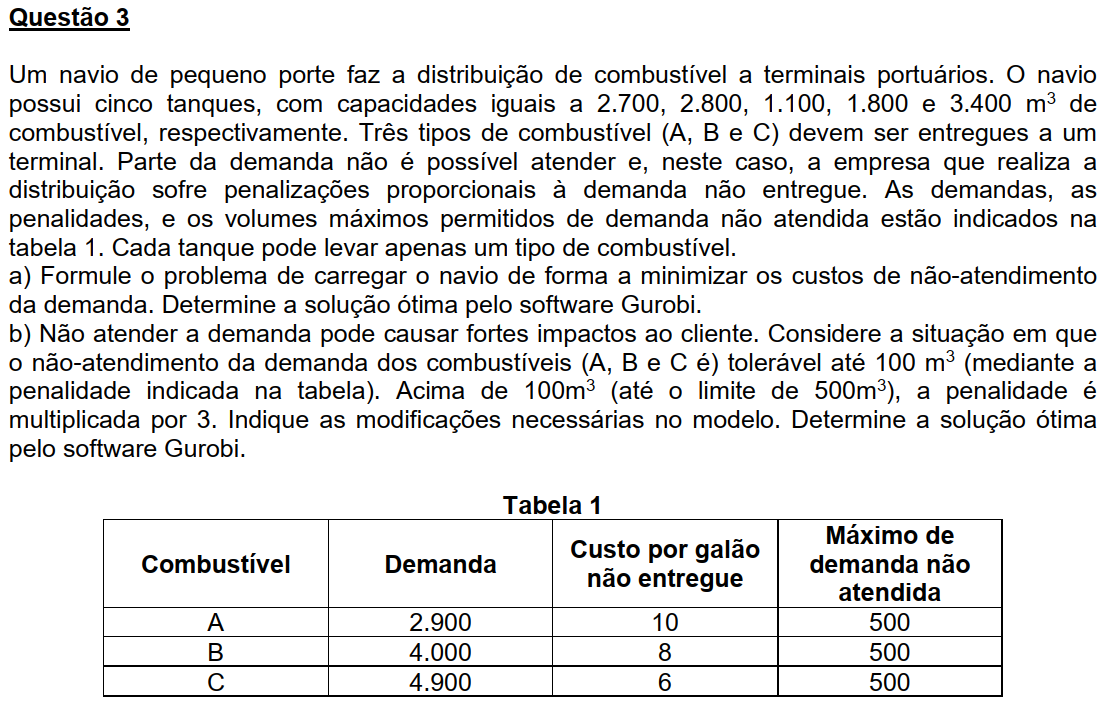

In [1]:
from IPython.display import Image
Image(filename='..\images\Questão_3.png')

In [2]:
import gurobipy as gp

def imprime_resultados_geral(modelo):
    m = modelo
    print('=========================================')
    print('Quantidade de restrições: ', m.NumConstrs)
    print('Quantidade de variáveis: ', m.NumVars)
    print('=========================================')
    print('Status do modelo: ', m.Status)
    print('=========================================')
    print('Valor da função objetivo: ', m.ObjVal)
    print('=========================================')
    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))
    print('=========================================')


'''======================= Define os Parâmetros utilizados no modelo ======================='''
V_max_tanque = [2700, 2800, 1100, 1800, 3400]

Demanda_de_combustivel = [2900, 4000, 4900]

Demanda_maxima_n_atendida = [500, 500, 500]

Penalidade = [10, 8, 6]

'''Define o BIG M'''
M = 100000

'''Cria o modelo'''
modelo = gp.Model(name="problemadoscombustiveis")

'''Bin_tipo representa se um combustível j será armazenado em um tanque i'''
Bin_tipo = modelo.addVars(range(0, 5), range(0, 3),
                   vtype=gp.GRB.BINARY,
                   name='Bin_tipo'
                   )

'''======================= Define as variáveis utilizados no modelo ======================='''
'''Define a quantidade de combustível j armazenado em um tanque i'''
Vol = modelo.addVars(range(0, 5), range(0, 3),
                   vtype=gp.GRB.INTEGER,
                   name='Vol'
                   )

'''Identifica a quantidade de combustível j que foi armazenado em todos os tanques i'''
Vol_atend = modelo.addVars(range(0, 3),
                   vtype=gp.GRB.INTEGER,
                   name='Vol'
                   )

'''Identifica a quantidade total de combustível j não atendida'''
Vol_n_atendido = modelo.addVars(range(0, 3),
                   vtype=gp.GRB.INTEGER,
                   lb=0,
                   name='Vol_n_atendido'
                   )

'''Variável binária que identifica se a quantidade de combustível j não atendida é menor ou igual a 100 ou maior do que 100'''
K = modelo.addVars(range(0, 3), range(0, 2),
                   vtype=gp.GRB.BINARY,
                   name='K'
                   )

'''R1: Garante que a quantidade de combustível j não atendida seja identificada corretamente e que apenas 1 opção seja atendida'''
modelo.addConstrs((gp.quicksum(Bin_tipo[i, j]
                   for j in range(0, 3)) == 1
                   for i in range(0, 5)), name='restricao_1')

'''R2: Identifica o volume não atendido'''
modelo.addConstrs((Vol_atend[j] == gp.quicksum(Vol[i, j] * Bin_tipo[i, j]
                   for i in range(0, 5))
                   for j in range(0, 3)),
                  name='restricao_2'
                  )

'''R3: Limita a quantidade de combustível a capacidade máxima do tanque'''
modelo.addConstrs((gp.quicksum(Vol[i, j] * Bin_tipo[i, j]
                   for j in range(0, 3)) <= V_max_tanque[i]
                   for i in range(0, 5)), name='restricao_3')

'''R4: Limita a quantidade máxima não atendida'''
modelo.addConstrs((Vol_n_atendido[j] <= Demanda_maxima_n_atendida[j]
                   for j in range(0, 3)), name='restricao_4')

'''R5: Identifica o volume de combustível j não atendido'''
modelo.addConstrs((Vol_n_atendido[j] == Demanda_de_combustivel[j] - Vol_atend[j]
                   for j in range(0, 3)),
                  name='restricao_5'
                  )

'''R6: Se o volume não atendido<=100 => k0=1 e k1 =0'''
modelo.addConstrs((Vol_n_atendido[j]*(K[j, 0] - K[j, 1]) <= 100
                   for j in range(0, 3)),
                  name='restricao_6'
                  )

'''R7: Se o volume não atendido>=100 => k0= 0 e k1= 1'''
modelo.addConstrs((Vol_n_atendido[j]*(K[j, 1] + K[j, 0]) >= 100
                   for j in range(0, 3)),
                  name='restricao_7'
                  )

'''R8: Garante que K0 ou K1 seja 1, que ao menos 1 seja selecionado e que os 2 não sejam selecionados ao mesmo tempo'''
modelo.addConstrs((K[j, 0] + K[j, 1] == 1
                   for j in range(0, 3)),
                  name='restricao_8'
                  )

'''Define a função objetivo'''
modelo.setObjective(gp.quicksum((Vol_n_atendido[j] * Penalidade[j] * K[j, 0] + Vol_n_atendido[j] * Penalidade[j] * K[j, 1] * 3)
                    for j in range(0, 3)
                    ),
                    sense=gp.GRB.MINIMIZE)

'''Otimiza o modelo'''
modelo.optimize()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 1600 Six-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14 rows, 42 columns and 30 nonzeros
Model fingerprint: 0x6113ff97
Model has 6 quadratic objective terms
Model has 14 quadratic constraints
Variable types: 0 continuous, 42 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
  QRHS range       [1e+02, 3e+03]
Presolve removed 3 rows and 3 columns
Presolve time: 0.00s
Presolved: 55 rows, 87 columns, 147 nonzeros
Presolved model has 30 SOS constraint(s)
Variable types: 0 continuous, 87 integer (33 binary)
Found

In [3]:
'''Caso tenha encontrado alguma solução, imprime os resultados'''
if modelo.SolCount > 0:  # problema tem solução
    imprime_resultados_geral(modelo)

modelo.write("Modelo_questao_1.lp")
modelo.write("Solution_questao_1.sol")

Quantidade de restrições:  14
Quantidade de variáveis:  42
Status do modelo:  2
Valor da função objetivo:  6400.0
Bin_tipo[0,0] 0
Bin_tipo[0,1] 1
Bin_tipo[0,2] 0
Bin_tipo[1,0] 1
Bin_tipo[1,1] 0
Bin_tipo[1,2] 0
Bin_tipo[2,0] 0
Bin_tipo[2,1] 1
Bin_tipo[2,2] 0
Bin_tipo[3,0] 0
Bin_tipo[3,1] 0
Bin_tipo[3,2] 1
Bin_tipo[4,0] 0
Bin_tipo[4,1] 0
Bin_tipo[4,2] 1
Vol[0,0] 0
Vol[0,1] 2700
Vol[0,2] 0
Vol[1,0] 2800
Vol[1,1] 0
Vol[1,2] 0
Vol[2,0] 0
Vol[2,1] 1100
Vol[2,2] 0
Vol[3,0] 0
Vol[3,1] 0
Vol[3,2] 1400
Vol[4,0] 0
Vol[4,1] 0
Vol[4,2] 3400
Vol[0] 2800
Vol[1] 3800
Vol[2] 4800
Vol_n_atendido[0] 100
Vol_n_atendido[1] 200
Vol_n_atendido[2] 100
K[0,0] 1
K[0,1] 0
K[1,0] -0
K[1,1] 1
K[2,0] 1
K[2,1] 0
